<a href="https://colab.research.google.com/github/cjer/covid/blob/master/israel_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
%matplotlib inline

In [178]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('whitegrid')

In [179]:
niv = pd.read_csv('data/corona_tested_individuals_ver_0033.csv.gz', 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-06-25,1,1,0,0,0,שלילי,No,זכר,Abroad
1,2020-06-25,1,0,0,0,0,שלילי,No,זכר,Abroad
2,2020-06-25,0,0,0,0,0,שלילי,No,נקבה,Abroad
3,2020-06-25,1,0,0,0,0,שלילי,No,נקבה,Abroad
4,2020-06-25,0,0,0,0,0,שלילי,No,נקבה,Other


In [180]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [181]:
bdi = pd.read_csv('data/corona_lab_tests_ver_0025.csv.gz', encoding='utf-8', parse_dates=[0,1])

In [182]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [183]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
1,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
2,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
3,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
4,2020-03-11,2020-03-11,שלילי,2,Yes,NaT


In [184]:
bdi.shape

(916547, 6)

In [185]:
bdi.corona_result.value_counts()

שלילי               857821
חיובי                44344
לא בוצע/פסול 999     10609
חיובי גבולי           2772
בעבודה                 605
לא ודאי                396
Name: corona_result, dtype: int64

In [186]:
niv.corona_result.value_counts()

שלילי    647224
חיובי     20718
אחר        7509
Name: corona_result, dtype: int64

In [187]:
niv.test_indication.value_counts()

Other                     633332
Abroad                     27323
Contact with confirmed     14796
Name: test_indication, dtype: int64

In [188]:
niv.age_60_and_above.value_counts()

No     182259
Yes     35719
Name: age_60_and_above, dtype: int64

In [189]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [190]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [191]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [192]:
rec = pd.read_csv('data/corona_recovered_ver_0024.csv.gz', encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,NaN,Abroad
1,22,9,30-39,NaN,Contact with confirmed
2,26,9,30-39,NaN,Contact with confirmed
3,28,9,30-39,NaN,Abroad
4,23,9,20-29,NaN,Contact with confirmed


In [193]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,7,1,15,6.857143,6,14
1,3,7302,2,76,15.967680,16,21906
2,4,3073,2,98,20.408396,20,12292
3,5,2188,4,76,24.010512,24,10940
4,6,1359,6,69,27.220015,27,8154
5,7,873,8,63,30.269187,30,6111
6,8,517,3,68,32.936170,32,4136
7,9,314,2,78,35.579618,35,2826
8,10,525,5,100,40.611429,40,5250


In [194]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(15).index]

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
15934,100,10+,60+,NaN,Contact with confirmed
15920,99,10+,60+,NaN,Other
8005,98,4,40-49,NaN,Other
7111,83,4,20-29,NaN,Other
272,78,9,60+,NaN,Contact with confirmed
15696,78,10+,0-19,NaN,Other
15894,78,10+,60+,NaN,Other
16045,77,10+,60+,NaN,Contact with confirmed
3298,76,5,0-19,NaN,Contact with confirmed
12687,76,3,40-49,NaN,Other


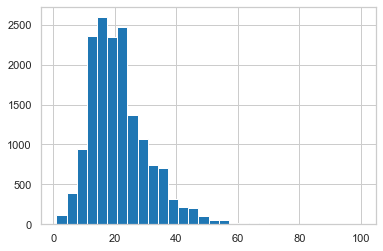

In [195]:
rec.days_between_pos_and_neg.hist(bins=30)

In [196]:
iso = pd.read_csv('data/corona_isolation_per_day_ver_0025.csv.gz',
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-06-24,17254,7890,3091,299
1,2020-06-23,15685,8254,2769,327
2,2020-06-22,14620,8684,2300,660
3,2020-06-21,13664,8690,2373,392
4,2020-06-20,12037,8805,1415,261


In [197]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [198]:
niv.age_60_and_above.value_counts()

No     182259
Yes     35719
Name: age_60_and_above, dtype: int64

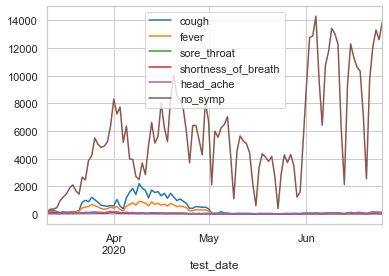

In [199]:
niv.groupby('test_date')[symptom_cols].sum().plot()

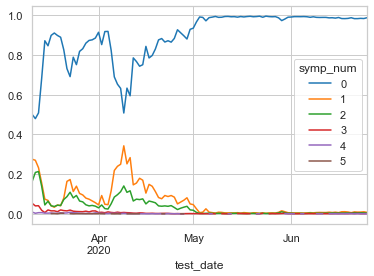

In [200]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

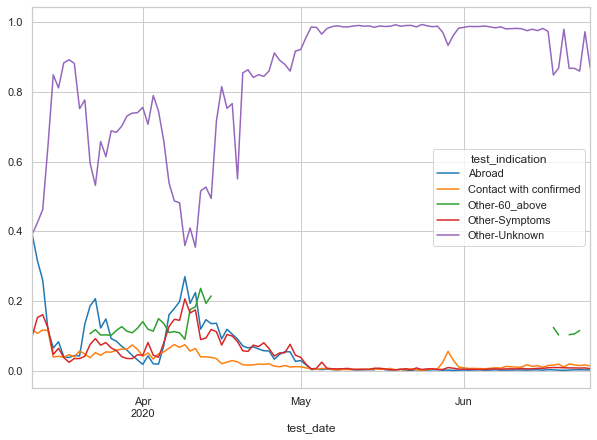

In [201]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

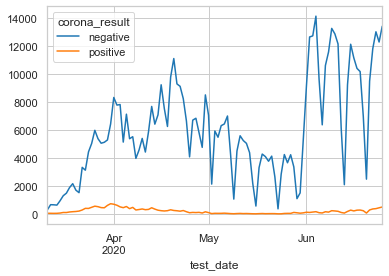

In [202]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [203]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

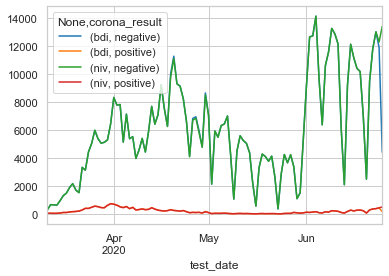

In [204]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

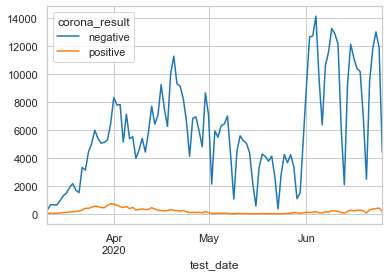

In [205]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [206]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,2,3
2020-03-12,21,7
2020-03-13,21,2
2020-03-14,24,1
2020-03-15,70,47
...,...,...
2020-06-21,4118,167
2020-06-22,5368,228
2020-06-23,4993,169


In [207]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-08,28.0,NaN,4199.0,18.0,NaN
2020-05-09,31.0,NaN,1057.0,9.0,NaN
2020-05-12,46.0,NaN,5250.0,19.0,NaN
2020-05-14,57.0,1.0,4379.0,16.0,NaN
2020-05-15,28.0,NaN,2183.0,7.0,NaN
2020-05-16,25.0,NaN,559.0,4.0,NaN
2020-05-17,58.0,NaN,3313.0,15.0,NaN
2020-05-19,32.0,NaN,4104.0,12.0,NaN
2020-05-20,42.0,NaN,3768.0,16.0,NaN


In [208]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-06-21,66.0,NaN,9510.0,280.0,NaN
2020-06-22,81.0,NaN,11827.0,351.0,NaN
2020-06-23,113.0,NaN,13029.0,373.0,NaN
2020-06-24,60.0,6.0,11911.0,420.0,NaN
2020-06-25,49.0,NaN,4412.0,158.0,NaN


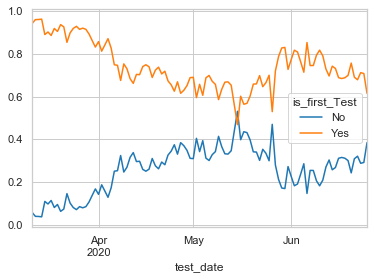

In [209]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

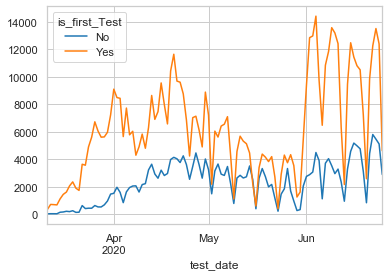

In [210]:
ti.plot()

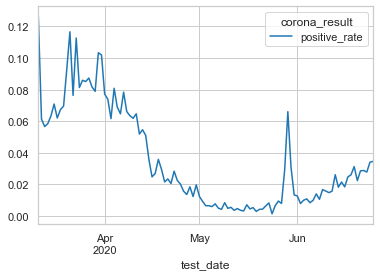

In [211]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [212]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-06-21,4409,9856
2020-06-22,5797,12259
2020-06-23,5461,13515
2020-06-24,5109,12397
2020-06-25,2885,4619


In [213]:
ti.Yes.sum() + ti.No.sum()

916547

In [214]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [215]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']])

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [129]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'מונשמים': 'resp'}

In [216]:
hos = (pd.read_csv('data/corona_hospitalization_ver_0014.csv.gz', encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/corona_hospitalization_ver_0014.csv.gz'

In [ ]:
(hos[['date', 'critical', 'resp']].set_index('date').plot())